a Sanford Health dataset that represents the ED (Emergency Department) volumes presenting to 4 Sanford Health medical centers 1/1/18 through 8/31/2025.
The dataset provides the facility, date, hour, reason, number of total encounters, number of those encounters admitted to a floor.

Forecast the future daily volumes (number of total encounters and the number of encounters admitted to a floor) for the month of September and October CY2025 (where CY means calendar year), by day.

# Basic things

In [3]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

df = pl.read_csv("DSU-Dataset.csv")

In [4]:
df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,f64,str,i64,i64
"""A""","""2018-01-01""",0.0,"""BREATHING PROBLEM""",1,1
"""A""","""2018-01-01""",0.0,"""BURN""",1,0
"""A""","""2018-01-01""",0.0,"""SHAKING""",1,1
"""A""","""2018-01-01""",0.0,"""VOMITING""",1,0
"""A""","""2018-01-01""",1.0,"""FROSTBITE""",1,0


In [5]:
col = df["Date"].str.to_date()
df = df.with_columns(col)

In [6]:
df.describe()

statistic,Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,str,f64,str,f64,f64
"""count""","""1174310""","""1174310""",1.17431e6,"""1168105""",1.17431e6,1.17431e6
"""null_count""","""0""","""0""",0.0,"""6205""",0.0,0.0
"""mean""",null,"""2021-12-05 23:13:59.314320""",13.549324,null,1.084646,0.291522
"""std""",null,null,6.142173,null,0.322814,0.47727
"""min""","""A""","""2018-01-01""",0.0,"""ABDOMINAL AORTIC ANEURYSM""",1.0,0.0
"""25%""",null,"""2019-12-23""",10.0,null,1.0,0.0
"""50%""",null,"""2021-12-30""",14.0,null,1.0,0.0
"""75%""",null,"""2023-11-11""",19.0,null,1.0,1.0
"""max""","""D""","""2025-08-31""",23.0,"""WRIST PAIN""",8.0,5.0


The forecasted volumes are not to be broken down by reason of visit.

In [7]:
import numpy as np

columns = df.columns

for col in columns:
    print(f"Column {col} has {df[col].is_null().sum()} missing values.")

print(f"ED Enc has a min of {df['ED Enc'].min()} and a max of {df['ED Enc'].max()} at a particular hour for a certain reason")
print(f"ED Enc Admitted has a min of {df['ED Enc Admitted'].min()} and a max of {df['ED Enc Admitted'].max()} at a particular hour for a certain reason")
print(f"There are sites: {', '.join([site for site in df['Site'].unique()])}")

Column Site has 0 missing values.
Column Date has 0 missing values.
Column Hour has 0 missing values.
Column REASON_VISIT_NAME has 6205 missing values.
Column ED Enc has 0 missing values.
Column ED Enc Admitted has 0 missing values.
ED Enc has a min of 1 and a max of 8 at a particular hour for a certain reason
ED Enc Admitted has a min of 0 and a max of 5 at a particular hour for a certain reason
There are sites: B, C, A, D


# Popularity of visit reasons (for fun) (and a word cloud (for extra fun))

In [8]:
reason_df = df.group_by("REASON_VISIT_NAME").agg(pl.col("ED Enc").sum().alias("Total ED Enc"), pl.col("ED Enc Admitted").sum().alias("Total ED Enc Admitted"))
reason_df = reason_df.join(df["REASON_VISIT_NAME"].value_counts().rename({"count": "Count of appearances"}), on="REASON_VISIT_NAME")
reason_df = reason_df.with_columns(
    (pl.col("Total ED Enc Admitted") / pl.col("Total ED Enc") * 100).alias("Percentage ED Admitted per Enc"),
)
reason_df = reason_df.sort("Total ED Enc", descending=True)

reason_df.head()

REASON_VISIT_NAME,Total ED Enc,Total ED Enc Admitted,Count of appearances,Percentage ED Admitted per Enc
str,i64,i64,u32,f64
"""ABDOMINAL PAIN""",123575,36534,94739,29.564232
"""CHEST PAIN""",82502,31341,68213,37.98817
"""FALL""",52970,19569,46042,36.943553
"""SHORTNESS OF BREATH""",48018,27345,42243,56.947395
"""BACK PAIN""",35338,5849,32299,16.551588


(-0.5, 399.5, 199.5, -0.5)

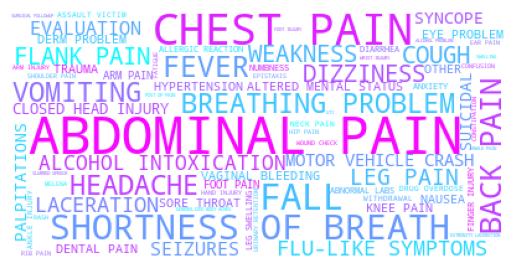

In [9]:
from wordcloud import WordCloud

reason_edenc_dict = dict(zip(reason_df["REASON_VISIT_NAME"], reason_df["Total ED Enc"]))

wc = WordCloud(background_color="white", max_words=200, colormap="cool").generate_from_frequencies(reason_edenc_dict)
plt.imshow(wc)
plt.axis("off")

In [10]:
# visit reasons for each month and site
monthly_reasons = df.with_columns(
    pl.col("Date").dt.year().alias("Year"),
    pl.col("Date").dt.month().alias("Month"),
).group_by("Site", "Year", "Month", "REASON_VISIT_NAME").agg(pl.col("ED Enc").sum().alias("Total ED Enc"), pl.col("ED Enc Admitted").sum().alias("Total ED Enc Admitted"))

monthly_reasons.head()

Site,Year,Month,REASON_VISIT_NAME,Total ED Enc,Total ED Enc Admitted
str,i32,i8,str,i64,i64
"""D""",2018,7,"""MORNING SICKNESS""",1,0
"""D""",2024,7,"""NOSE BLEED""",1,0
"""B""",2023,10,"""PELVIC PAIN""",7,1
"""B""",2023,9,"""WOUND DEHISCENCE""",1,0
"""B""",2022,7,"""INSOMNIA""",1,0


In [ ]:
#monthly_reasons.write_csv("web/reasons.csv")

In [12]:
# normalize values

site_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
reason_dict = {reason: idx for idx, reason in enumerate(df['REASON_VISIT_NAME'].unique())}

df_friendly = df.with_columns(
    [pl.col("Date").dt.year().alias("Year").cast(pl.Int32),
     pl.col("Date").dt.month().alias("Month").cast(pl.Int32),
     pl.col("Date").dt.day().alias("Day").cast(pl.Int32),
     pl.col("Date").dt.weekday().alias("Weekday").cast(pl.Int32)]).drop("Date")

df_friendly = df_friendly.select(["Site", "Year", "Month", "Day", "Weekday", "Hour", "REASON_VISIT_NAME", "ED Enc", "ED Enc Admitted"])
df_friendly = df_friendly.with_columns(
    pl.col('Site').replace(site_dict).cast(pl.Int32),
    pl.col('REASON_VISIT_NAME').replace(reason_dict).cast(pl.Int32)
)

df_friendly.head()

Site,Year,Month,Day,Weekday,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
i32,i32,i32,i32,i32,f64,i32,i64,i64
0,2018,1,1,1,0.0,684,1,1
0,2018,1,1,1,0.0,454,1,0
0,2018,1,1,1,0.0,528,1,1
0,2018,1,1,1,0.0,12,1,0
0,2018,1,1,1,1.0,481,1,0


In [13]:
# Sometimes datetime features are more useful in their original datetime format (like for plotting)
df_friendly_datetime = df.with_columns(
    [pl.col("Date").dt.weekday().alias("Weekday").cast(pl.Int32),
     pl.col("Site").replace(site_dict).cast(pl.Int32),
     pl.col('REASON_VISIT_NAME').replace(reason_dict).cast(pl.Int32)]
)
df_friendly_datetime.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted,Weekday
i32,date,f64,i32,i64,i64,i32
0,2018-01-01,0.0,215,1,1,1
0,2018-01-01,0.0,760,1,0,1
0,2018-01-01,0.0,398,1,1,1
0,2018-01-01,0.0,804,1,0,1
0,2018-01-01,1.0,293,1,0,1


In [14]:
# df_friendly.write_csv("./DSU-Dataset-Feature-Engineering.csv")

# BTW Monday = 1 and Sunday = 7

# Trends in months

Combine encounters by months, then facilities. See trends over months

In [16]:
start_date = df["Date"].min()
end_date = df["Date"].max()
month_date_range = pl.date_range(start=start_date, end=end_date, interval="1mo",  eager=True)

reverse_site_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

monthly_site_data = df_friendly.group_by(["Year", "Month", "Site"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
monthly_site_data = monthly_site_data.with_columns(
    monthly_site_data["Site"].replace_strict(reverse_site_dict)
)
print(monthly_site_data.head())

monthly_data = df_friendly.group_by(["Year", "Month"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
print(monthly_data.head())

shape: (5, 5)
┌──────┬───────┬──────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Site ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---  ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ str  ┆ i64    ┆ i64             │
╞══════╪═══════╪══════╪════════╪═════════════════╡
│ 2020 ┆ 7     ┆ C    ┆ 2753   ┆ 844             │
│ 2020 ┆ 7     ┆ A    ┆ 3508   ┆ 1098            │
│ 2025 ┆ 5     ┆ D    ┆ 2433   ┆ 463             │
│ 2023 ┆ 3     ┆ A    ┆ 3820   ┆ 1250            │
│ 2018 ┆ 9     ┆ D    ┆ 2219   ┆ 382             │
└──────┴───────┴──────┴────────┴─────────────────┘
shape: (5, 4)
┌──────┬───────┬────────┬─────────────────┐
│ Year ┆ Month ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i64    ┆ i64             │
╞══════╪═══════╪════════╪═════════════════╡
│ 2021 ┆ 7     ┆ 15000  ┆ 3834            │
│ 2018 ┆ 3     ┆ 13101  ┆ 3347            │
│ 2018 ┆ 9     ┆ 13447  ┆ 3384            │
│ 2018 ┆ 12    ┆ 13370  ┆ 3494            │
│ 2019 ┆ 1     

In [16]:
# monthly_site_data.write_csv("./DSU-Dataset-Monthly-Site-Summary.csv")
# monthly_data.write_csv("./DSU-Dataset-Monthly-Summary.csv")

# Monthly by Site
The next three figures show monthly data by site: the first has both ED Enc and ED Enc Admitted, and the second/third are individual line plots.

In [13]:
daily_site_data = df_friendly.group_by(["Year", "Month", "Day", "Weekday", "Site"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
daily_data = df_friendly.group_by(["Year", "Month", "Weekday", "Day"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

print(daily_site_data.head())
print(daily_data.head())

shape: (5, 7)
┌──────┬───────┬─────┬─────────┬──────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Day ┆ Weekday ┆ Site ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ --- ┆ ---     ┆ ---  ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i32 ┆ i32     ┆ i32  ┆ i64    ┆ i64             │
╞══════╪═══════╪═════╪═════════╪══════╪════════╪═════════════════╡
│ 2024 ┆ 8     ┆ 9   ┆ 5       ┆ 0    ┆ 130    ┆ 40              │
│ 2019 ┆ 6     ┆ 6   ┆ 4       ┆ 0    ┆ 112    ┆ 43              │
│ 2018 ┆ 7     ┆ 21  ┆ 6       ┆ 3    ┆ 84     ┆ 9               │
│ 2024 ┆ 9     ┆ 23  ┆ 1       ┆ 0    ┆ 140    ┆ 43              │
│ 2018 ┆ 11    ┆ 13  ┆ 2       ┆ 2    ┆ 85     ┆ 30              │
└──────┴───────┴─────┴─────────┴──────┴────────┴─────────────────┘
shape: (5, 6)
┌──────┬───────┬─────────┬─────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Weekday ┆ Day ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---     ┆ --- ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i32     ┆ i32 ┆ i64    ┆ i64          

In [64]:
# monthly_day_site_data.write_csv("./DSU-Dataset-Monthly-Day-Site-Summary.csv")
# monthly_day_data.write_csv("./DSU-Dataset-Monthly-Day-Summary.csv")

# Daily by Site

The next three figures illustrates the data but sums up ED Enc and ED Enc Admitted by day rather than month.

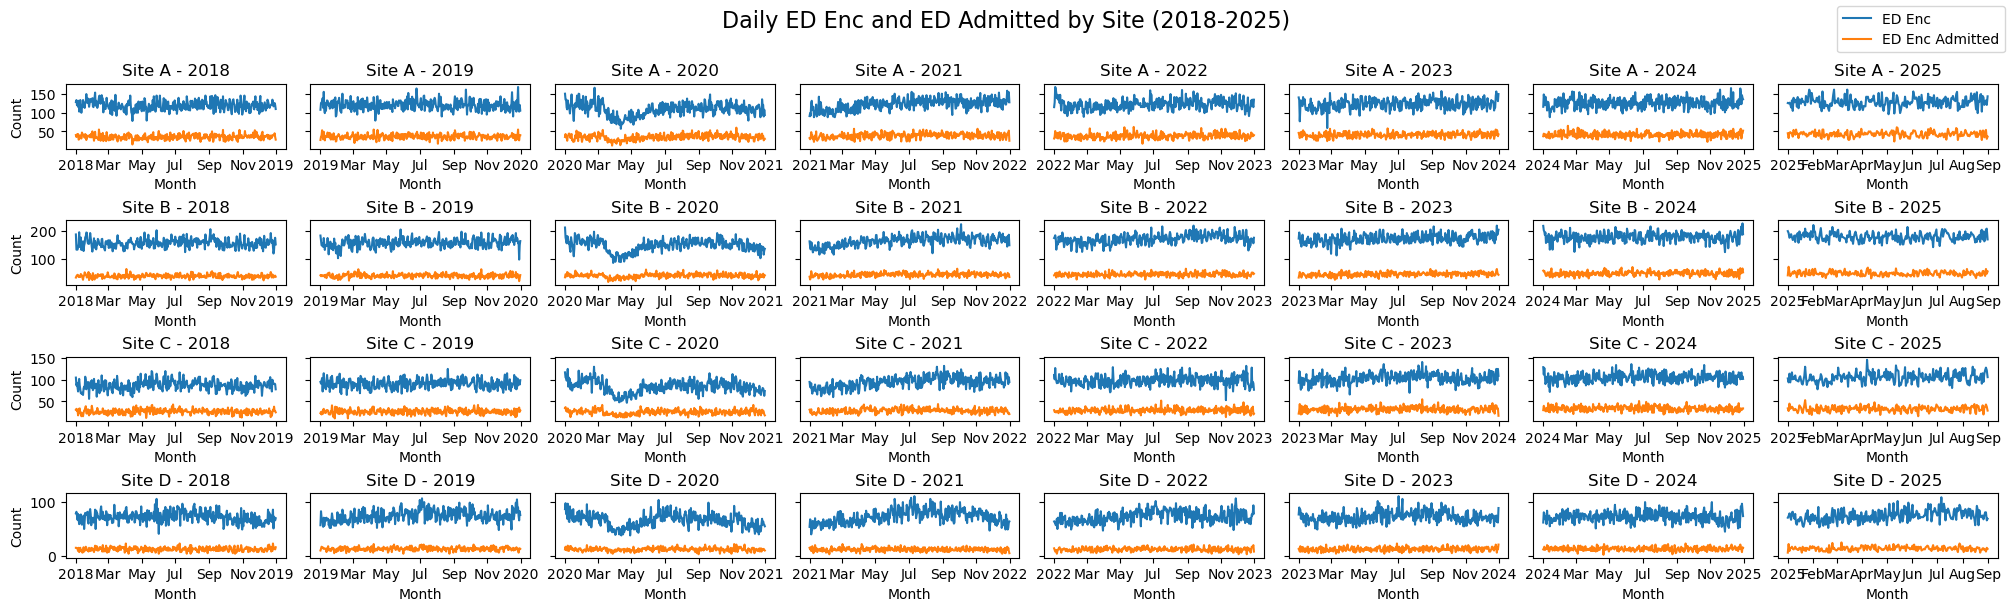

In [ ]:
import matplotlib.dates as mdates

# same thing but with days
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

plot_df = daily_site_data.with_columns(
    [pl.col("Site").replace_strict(reverse_site_dict),
     pl.datetime(
            pl.col("Year"),
            pl.col("Month"),
            pl.col("Day")
     ).alias("Date")
    ]
)

for i, year in enumerate(range(2018, 2026)):
    for i, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Date').dt.year() == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc', ax=axes[i, i], label="ED Enc" if i == 0 and i == 0 else "", legend=False)
        sns.lineplot(data=plot_df.filter((pl.col('Date').dt.year() == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc Admitted', ax=axes[i, i], label="ED Enc Admitted" if i == 0 and i == 0 else "", legend=False)
        axes[i, i].set_title(f'Site {site} - {year}')
        axes[i, i].set_xlabel('Month')
        axes[i, i].set_ylabel('Count')
        axes[i, i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i, i].xaxis.get_major_locator()))


fig.legend(loc='outside upper right')
fig.suptitle('Daily ED Enc and ED Admitted by Site (2018-2025)', fontsize=16)

plt.show()


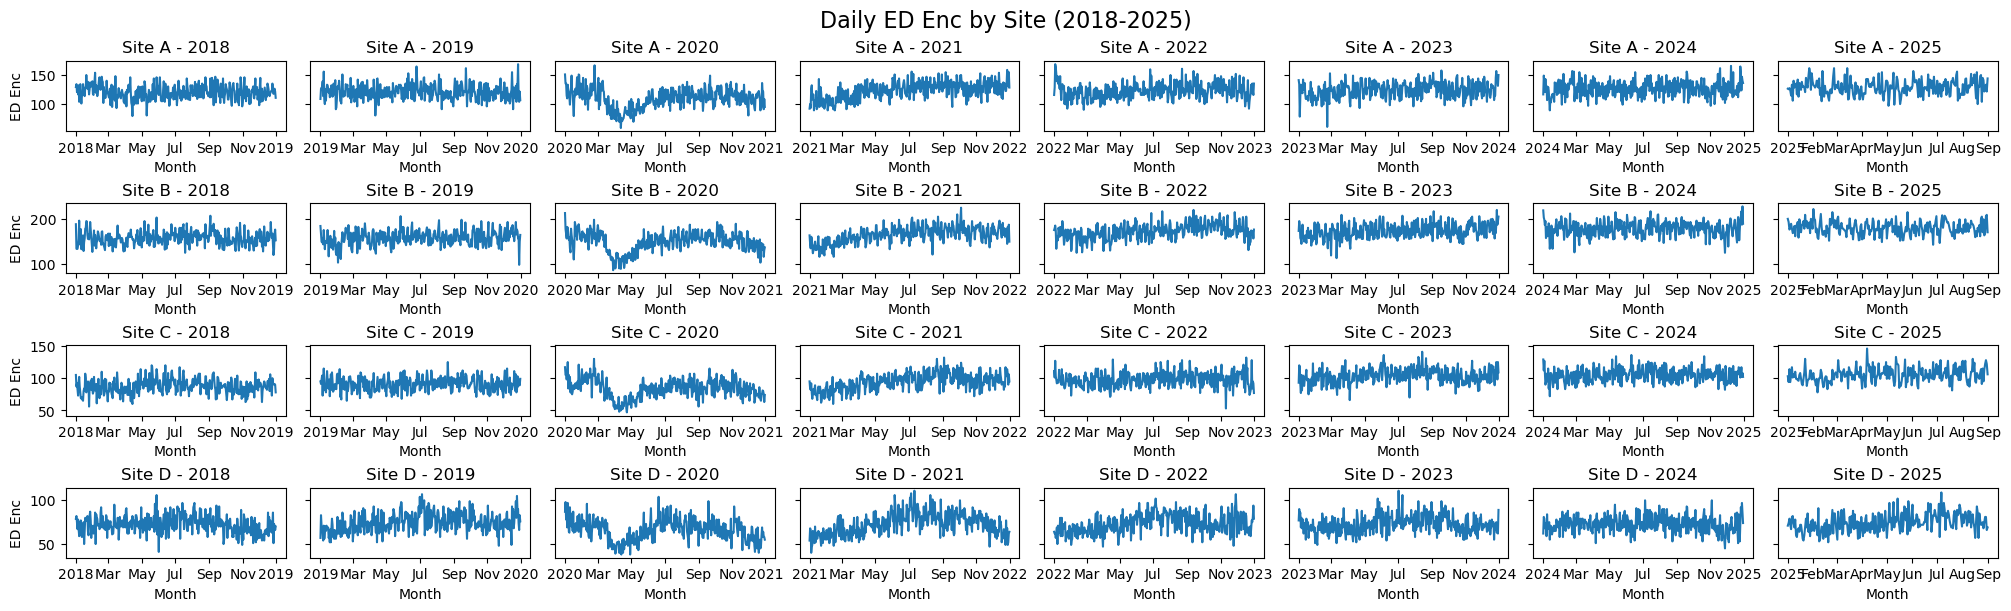

In [ ]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for i, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc', ax=axes[i, i])
        axes[i, i].set_title(f'Site {site} - {year}')
        axes[i, i].set_xlabel('Month')
        axes[i, i].set_ylabel('ED Enc')
        axes[i, i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i, i].xaxis.get_major_locator()))

fig.suptitle('Daily ED Enc by Site (2018-2025)', fontsize=16)

plt.show()


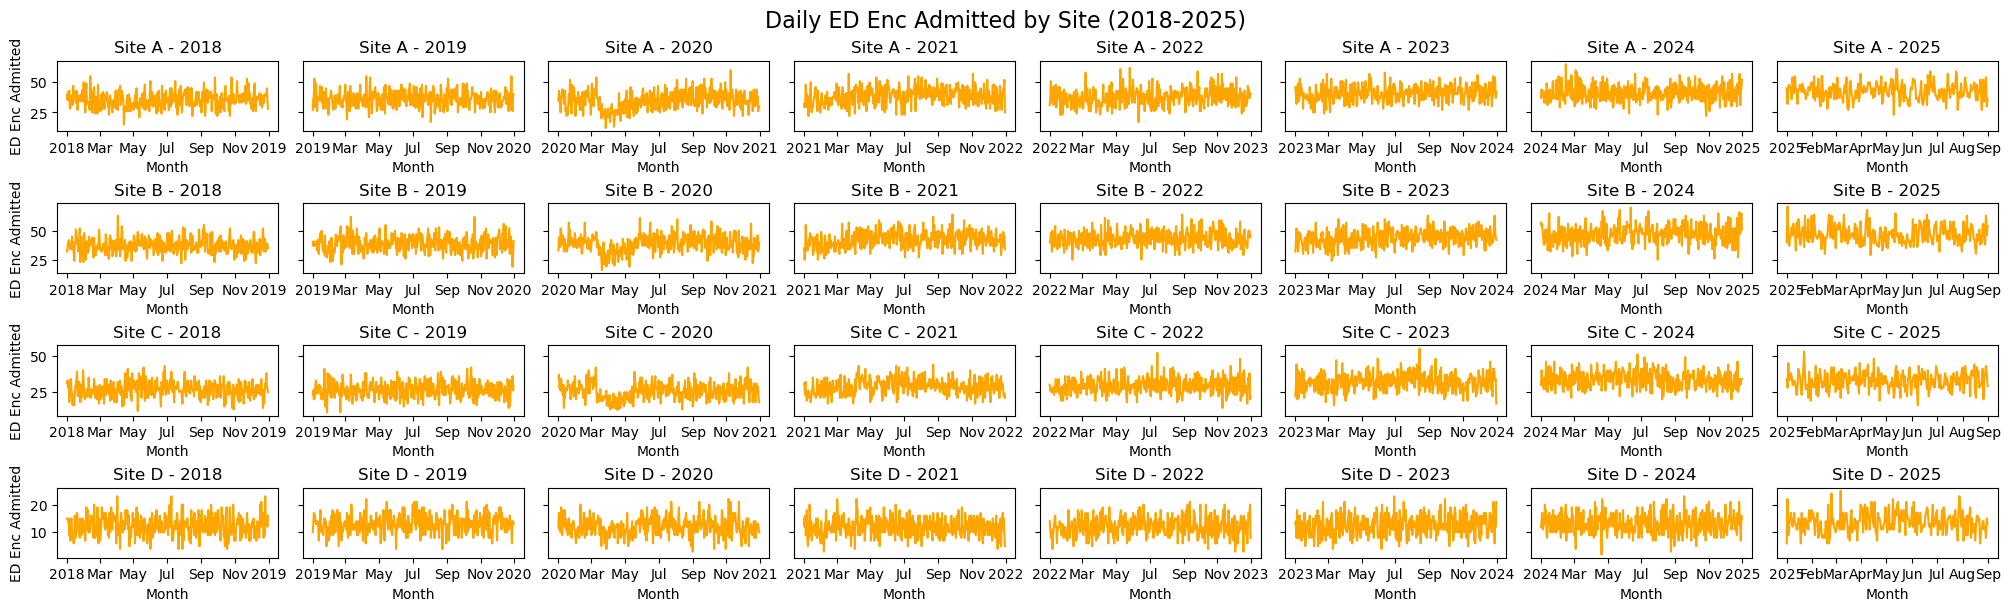

In [ ]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for i, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc Admitted', ax=axes[i, i], color='orange')
        axes[i, i].set_title(f'Site {site} - {year}')
        axes[i, i].set_xlabel('Month')
        axes[i, i].set_ylabel('ED Enc Admitted')
        axes[i, i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i, i].xaxis.get_major_locator()))

fig.suptitle('Daily ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


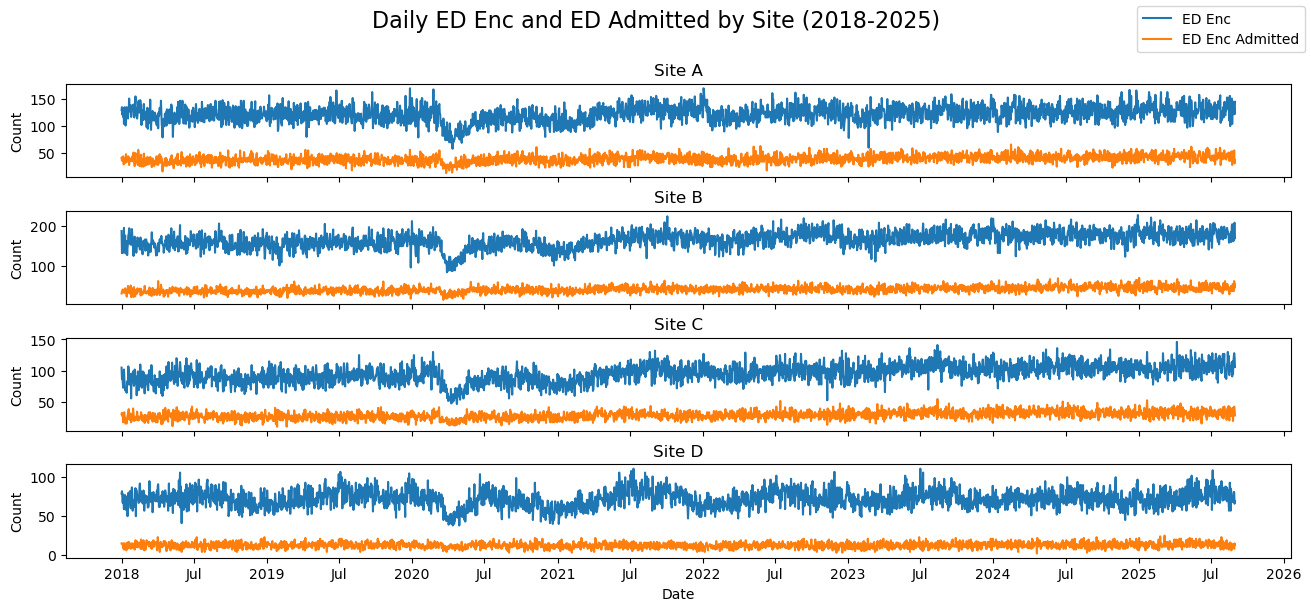

In [27]:
import matplotlib.dates as mdates

# same thing but with days
fig, axes = plt.subplots(4, 1, layout="constrained", figsize=(13, 6), sharex=True, sharey="row")

plot_df = daily_site_data.with_columns(
    [pl.col("Site").replace_strict(reverse_site_dict),
     pl.datetime(
            pl.col("Year"),
            pl.col("Month"),
            pl.col("Day")
     ).alias("Date")
    ]
)

for i, site in enumerate(['A', 'B', 'C', 'D']):
    sns.lineplot(data=plot_df.filter(pl.col('Site') == site),
                    x='Date', y='ED Enc', ax=axes[i], label="ED Enc" if i == 0 else "", legend=False)
    sns.lineplot(data=plot_df.filter(pl.col('Site') == site),
                    x='Date', y='ED Enc Admitted', ax=axes[i], label="ED Enc Admitted" if i == 0 else "", legend=False)
    axes[i].set_title(f'Site {site}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Count')
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=20))
    axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i].xaxis.get_major_locator()))


fig.legend(loc='outside upper right')
fig.suptitle('Daily ED Enc and ED Admitted by Site (2018-2025)', fontsize=16)

plt.show()


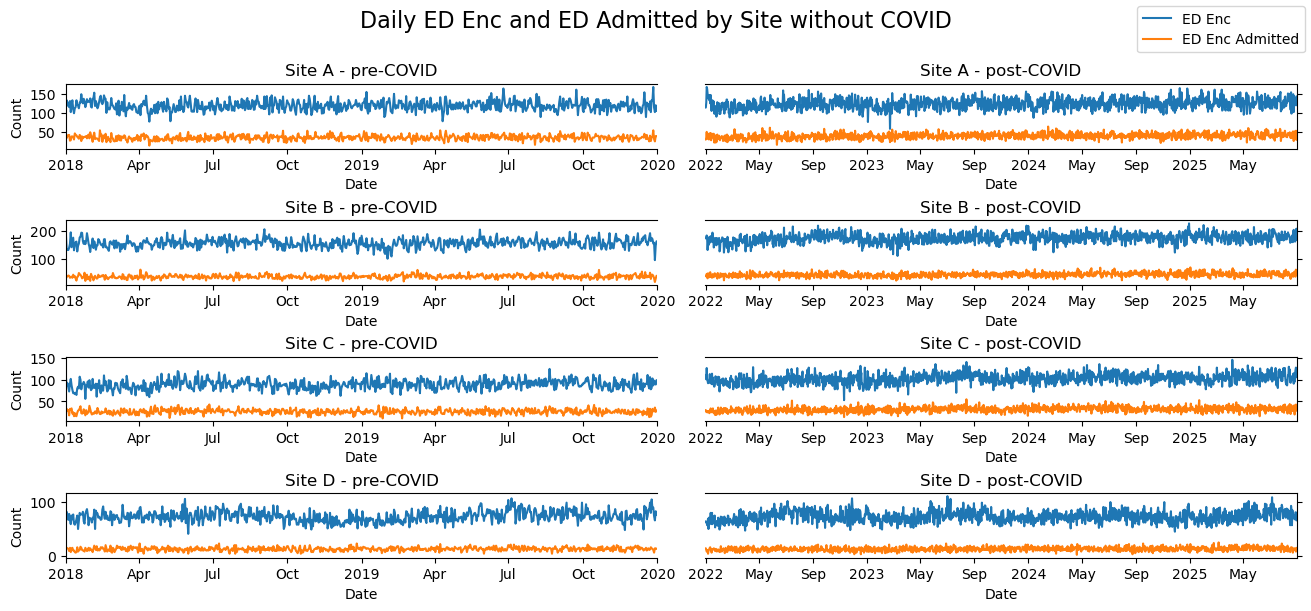

In [ ]:
import matplotlib.dates as mdates

# same thing but with days
fig, axes = plt.subplots(4, 2, layout="constrained", figsize=(13, 6), sharex=False, sharey="row")

plot_df = daily_site_data.with_columns(
    [pl.col("Site").replace_strict(reverse_site_dict),
     pl.datetime(
            pl.col("Year"),
            pl.col("Month"),
            pl.col("Day")
     ).alias("Date")
    ]
).filter(pl.col("Date").dt.year() != 2020).filter(pl.col("Date").dt.year() != 2021)

min_date = plot_df["Date"].min()
max_date = plot_df["Date"].max()
begin_covid_date = df.filter(pl.col("Date").dt.year() == 2020).select(pl.col("Date")).min()
end_covid_date = df.filter(pl.col("Date").dt.year() == 2021).select(pl.col("Date")).max()

for i, site in enumerate(['A', 'B', 'C', 'D']):
    for j in range(2):
        sns.lineplot(data=plot_df.filter(pl.col('Site') == site),
                        x='Date', y='ED Enc', ax=axes[i,j], label="ED Enc" if i == 0 and j == 0 else "", legend=False)
        sns.lineplot(data=plot_df.filter(pl.col('Site') == site),
                        x='Date', y='ED Enc Admitted', ax=axes[i,j], label="ED Enc Admitted" if i == 0 and j == 0 else "", legend=False)
        axes[i,j].set_title(f'Site {site} - pre-COVID' if j == 0 else f'Site {site} - post-COVID')
        axes[i,j].set_xlabel('Date')
        axes[i,j].set_ylabel('Count')
        axes[i,j].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i,j].xaxis.get_major_locator()))
    axes[i, 0].set_xlim(left=min_date, right=begin_covid_date)
    axes[i, 1].set_xlim(left=end_covid_date, right=max_date)
    axes[i, 0].spines.right.set_visible(False)
    axes[i, 1].spines.left.set_visible(False)
    axes[i, 0].tick_params(labelright=False)
    axes[i, 1].yaxis.tick_right()

fig.legend(loc='outside upper right')
fig.suptitle('Daily ED Enc and ED Admitted by Site without COVID', fontsize=16)

plt.show()


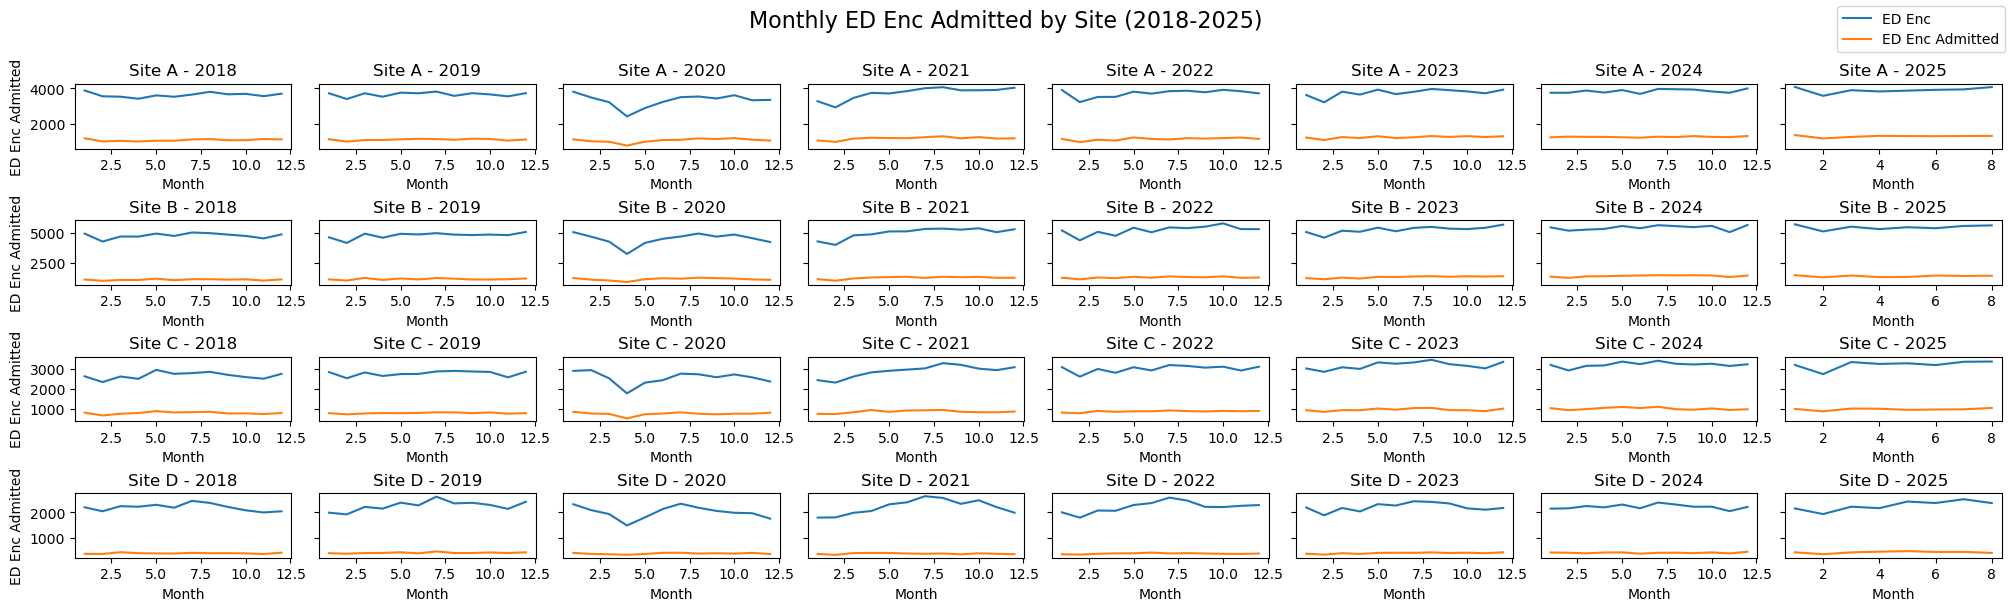

In [ ]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

plot_df = daily_site_data.group_by(['Year', 'Month', 'Site']).agg(pl.sum('ED Enc'), pl.sum('ED Enc Admitted'))
plot_df = plot_df.with_columns(
    plot_df["Site"].replace_strict(reverse_site_dict)
)

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[j, i], label="ED Enc" if i == 0 and j == 0 else "", legend=False)
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc Admitted', ax=axes[j, i], label="ED Enc Admitted" if i == 0 and j == 0 else "", legend=False)
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc Admitted')

fig.legend(loc='outside upper right')
fig.suptitle('Monthly ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


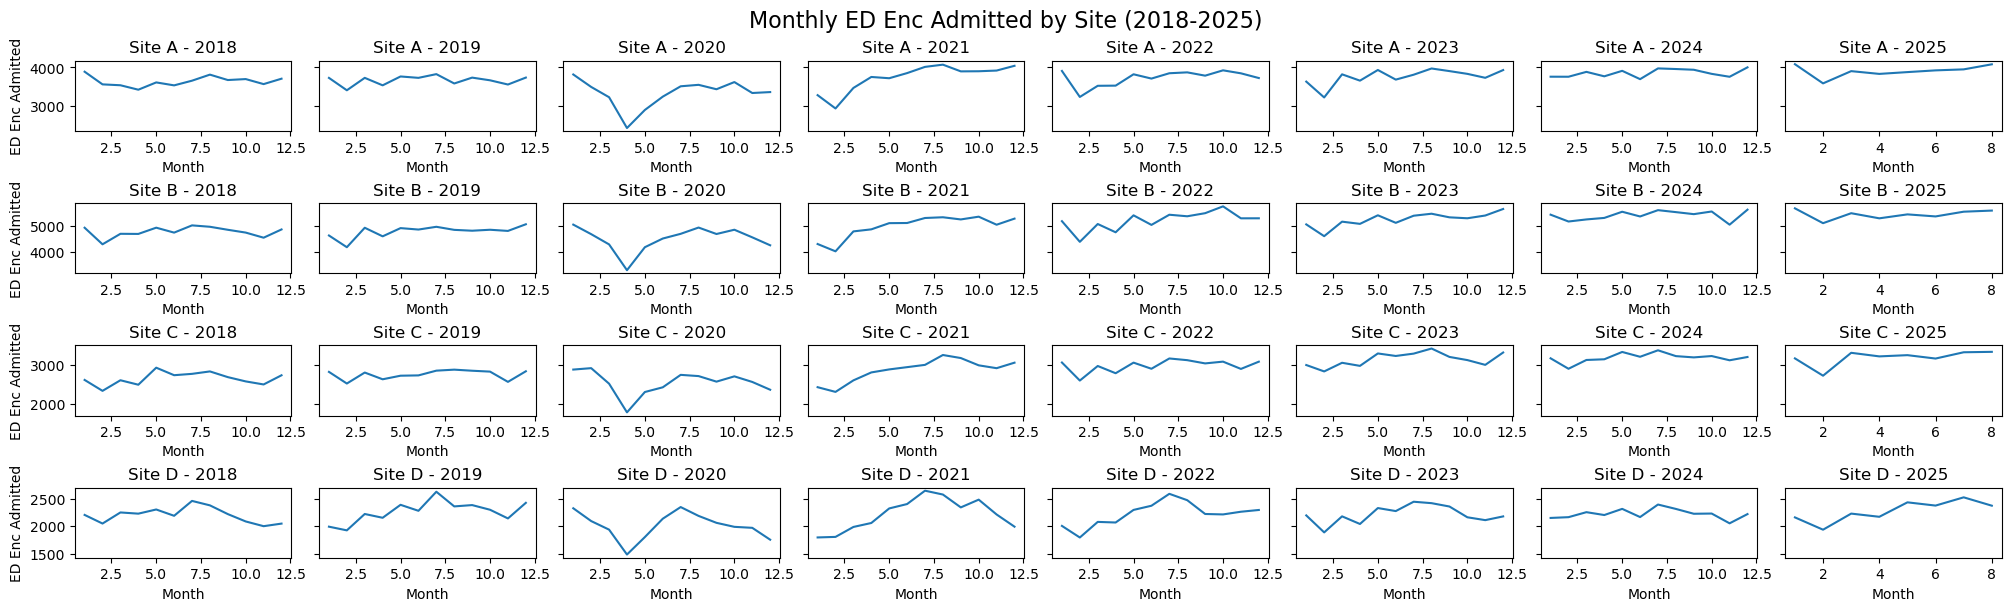

In [ ]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for i, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[i, i])
        axes[i, i].set_title(f'Site {site} - {year}')
        axes[i, i].set_xlabel('Month')
        axes[i, i].set_ylabel('ED Enc Admitted')

fig.suptitle('Monthly ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


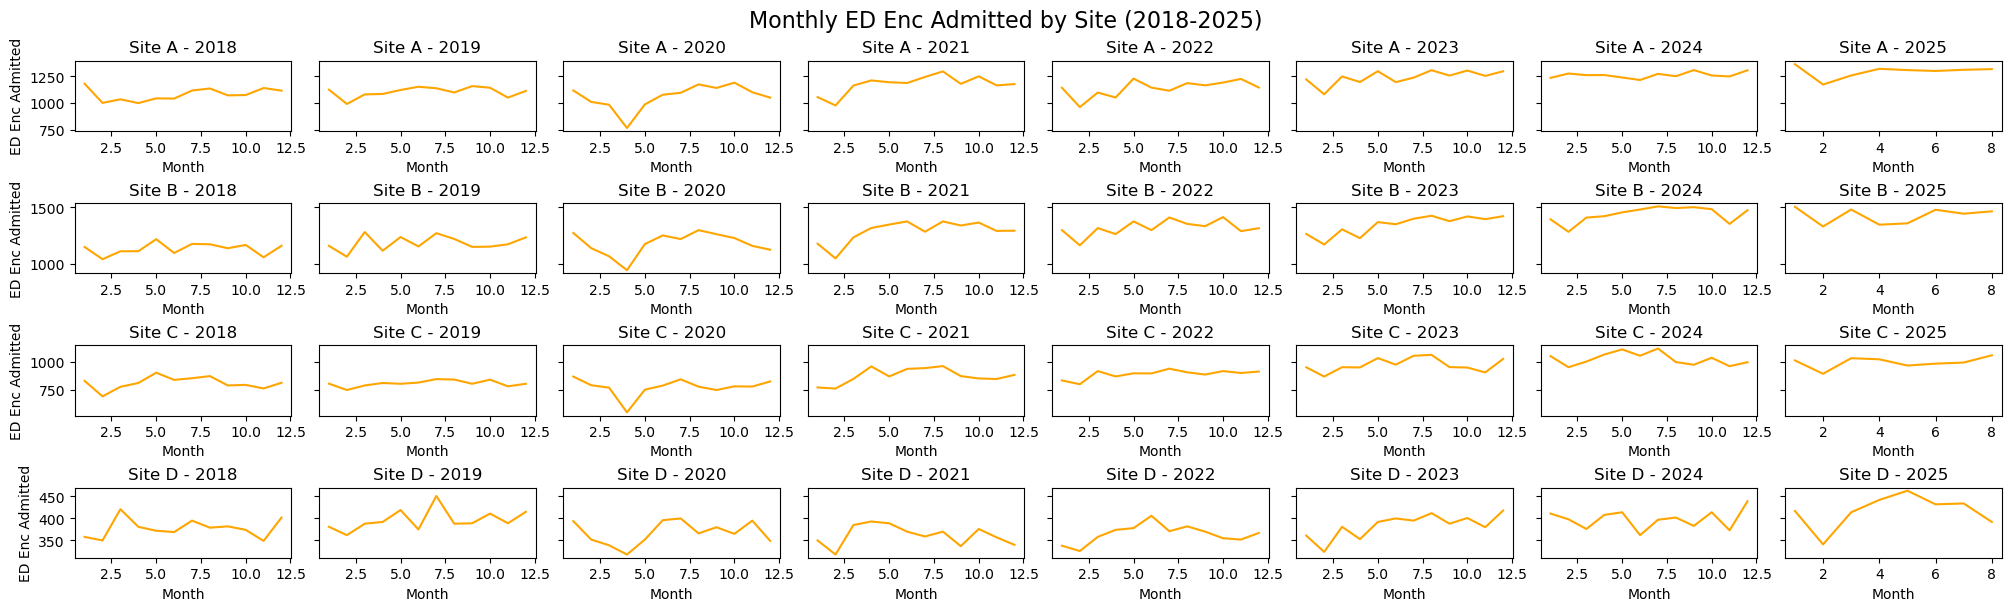

In [ ]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for i, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc Admitted', ax=axes[i, i], color='orange')
        axes[i, i].set_title(f'Site {site} - {year}')
        axes[i, i].set_xlabel('Month')
        axes[i, i].set_ylabel('ED Enc Admitted')

fig.suptitle('Monthly ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


# Overall graphs
Again, the next three figures illustrate overall sums of ED Enc and ED Enc Admitted.

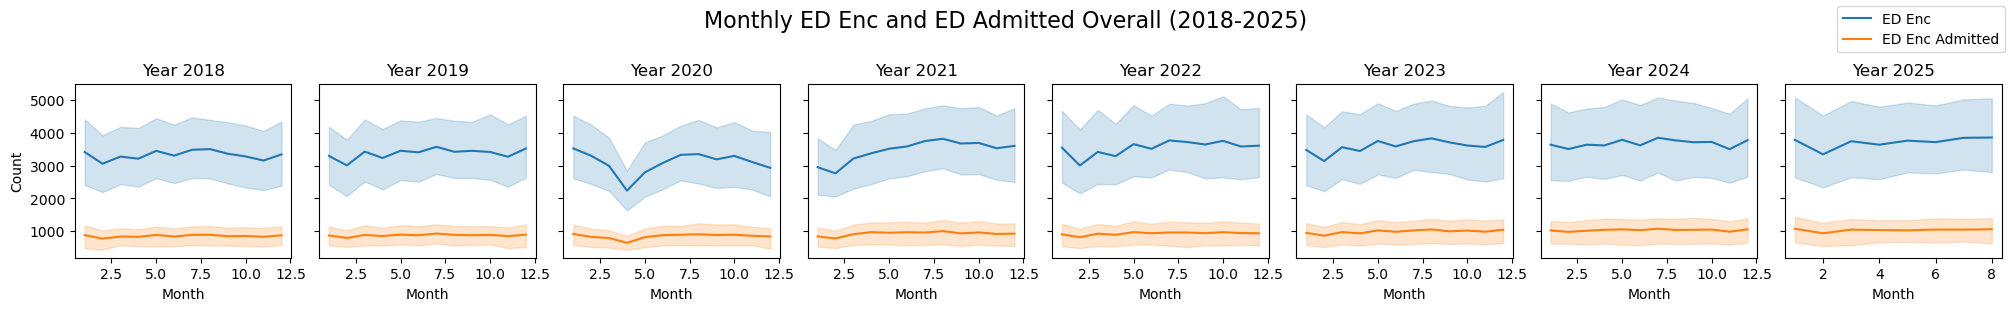

In [95]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=False, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc', ax=axes[i], label="ED Enc" if i == 0 else "", legend=False)
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc Admitted', ax=axes[i], label="ED Enc Admitted" if i == 0 else "", legend=False)
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Count')

fig.legend(loc='outside upper right')
fig.suptitle("Monthly ED Enc and ED Admitted Overall (2018-2025)", fontsize=16)
plt.show()

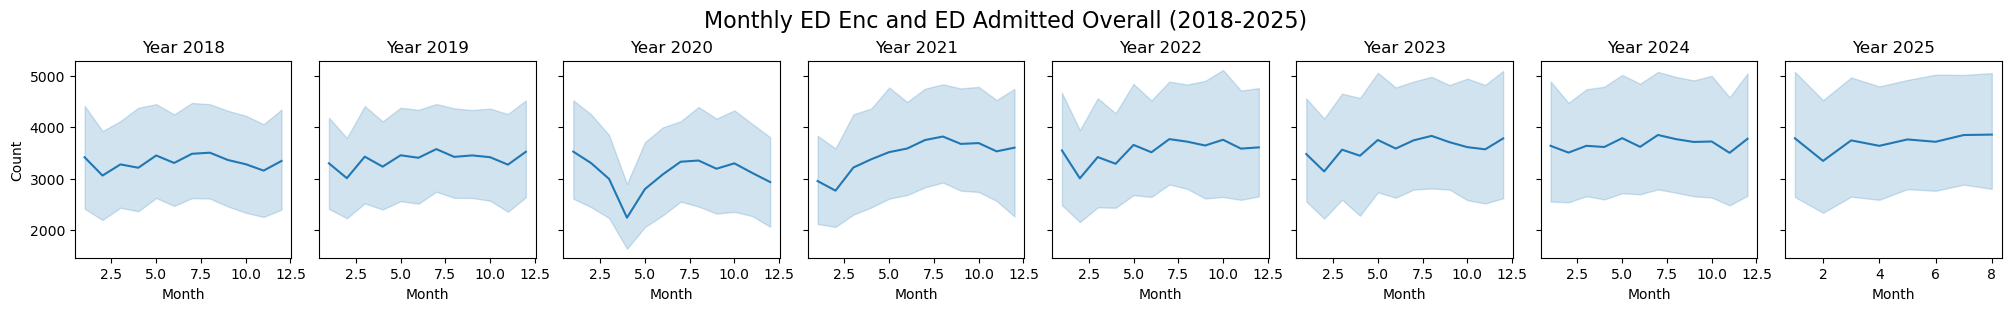

In [96]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=False, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc', ax=axes[i], label="ED Enc" if i == 0 else "", legend=False)
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Count')

fig.suptitle("Monthly ED Enc and ED Admitted Overall (2018-2025)", fontsize=16)
plt.show()

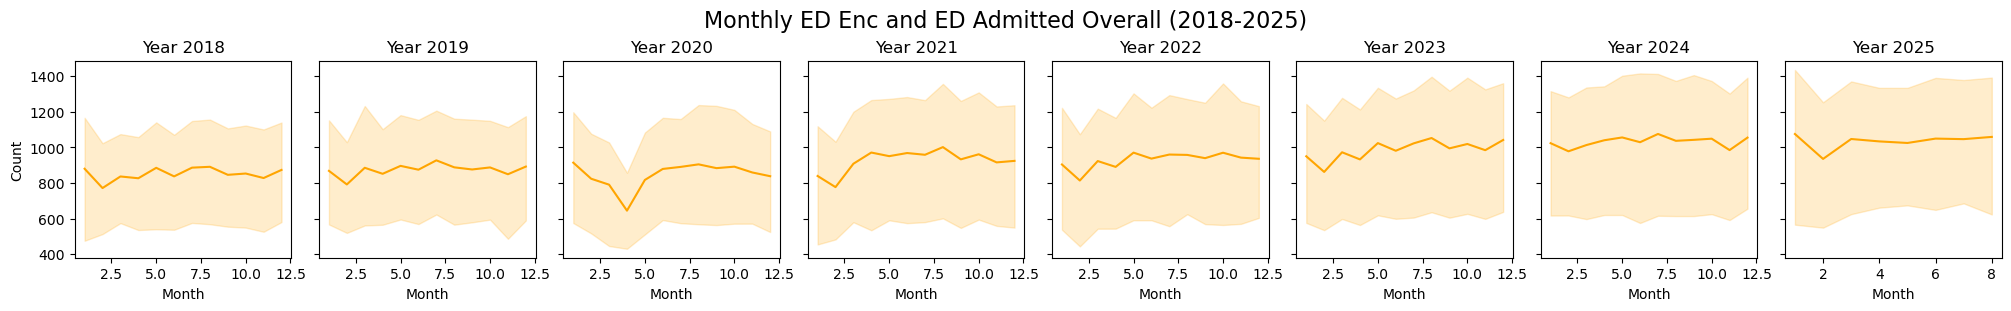

In [97]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=False, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Month', y='ED Enc Admitted', ax=axes[i], label="ED Enc Admitted" if i == 0 else "", legend=False, color='orange')
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Count')

fig.suptitle("Monthly ED Enc and ED Admitted Overall (2018-2025)", fontsize=16)
plt.show()

# Hourly blocks
We also want to predict within 6 hour blocks (0-5, 6-11, 12-17, 18-23).

In [74]:
df_friendly_datetime

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted,Weekday
i32,date,f64,i32,i64,i64,i32
0,2018-01-01,0.0,808,1,1,1
0,2018-01-01,0.0,278,1,0,1
0,2018-01-01,0.0,580,1,1,1
0,2018-01-01,0.0,414,1,0,1
0,2018-01-01,1.0,294,1,0,1
…,…,…,…,…,…,…
3,2025-08-31,22.0,604,1,0,7
3,2025-08-31,23.0,424,1,0,7
3,2025-08-31,23.0,103,1,0,7


We will define each hourly block as a sort of enum (but really it's a dict)

In [103]:
block_ranges = { 1: range(0, 6),
                 2: range(6, 12),
                 3: range(12, 18),
                 4: range(18, 24) }

hourly_blocks_data = df_friendly_datetime.with_columns(
    pl.col("Hour").map_elements(lambda hr: next(block for block, hrs in block_ranges.items() if hr in hrs)).alias("Hour")
)
hourly_blocks_data = hourly_blocks_data.group_by(["Site", "Date", "Hour"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
hourly_blocks_data = hourly_blocks_data.sort(["Site", "Date", "Hour"])
hourly_blocks_data = hourly_blocks_data.with_columns(
    [
        pl.col("Site").replace_strict(reverse_site_dict),
        pl.col("Date").dt.year().alias("Year"),
        pl.col("Date").dt.month().alias("Month"),
        pl.col("Date").dt.day().alias("Day"),
        pl.col("Date").dt.weekday().alias("Weekday"),
    ]
)

hourly_blocks_data.head()

Site,Date,Hour,ED Enc,ED Enc Admitted,Year,Month,Day,Weekday
str,date,i64,i64,i64,i32,i8,i8,i8
"""A""",2018-01-01,1,16,6,2018,1,1,1
"""A""",2018-01-01,2,25,8,2018,1,1,1
"""A""",2018-01-01,3,52,16,2018,1,1,1
"""A""",2018-01-01,4,36,10,2018,1,1,1
"""A""",2018-01-02,1,18,5,2018,1,2,2


In [104]:
hourly_blocks_data.write_csv("./DSU-Dataset-Hourly-Blocks-Summary.csv")

# Heatmap with feature engineering and without COVID years
New features include weekday

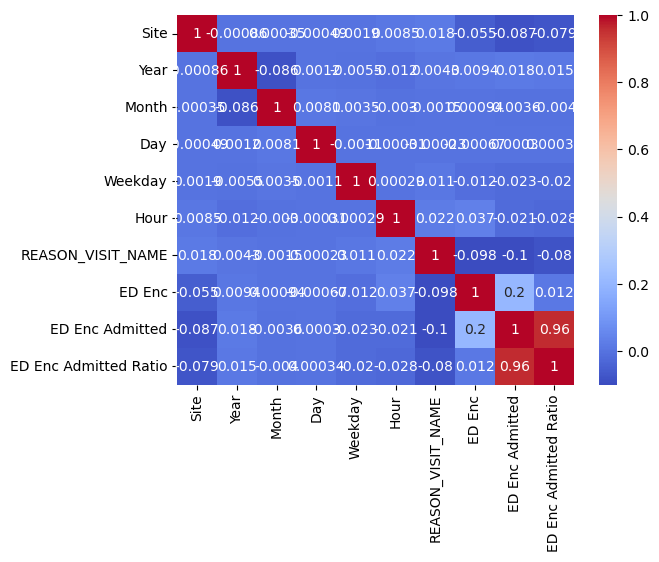

In [56]:
df_friendly_normal = df_friendly.filter((pl.col('Year') != 2020) & (pl.col('Year') != 2021))
df_friendly_normal = df_friendly.with_columns(
    (pl.col("ED Enc Admitted") / pl.col("ED Enc")).alias("ED Enc Admitted Ratio")
)

ax = sns.heatmap(df_friendly_normal.corr(), annot=True, cmap='coolwarm', xticklabels=df_friendly_normal.columns, yticklabels=df_friendly_normal.columns)

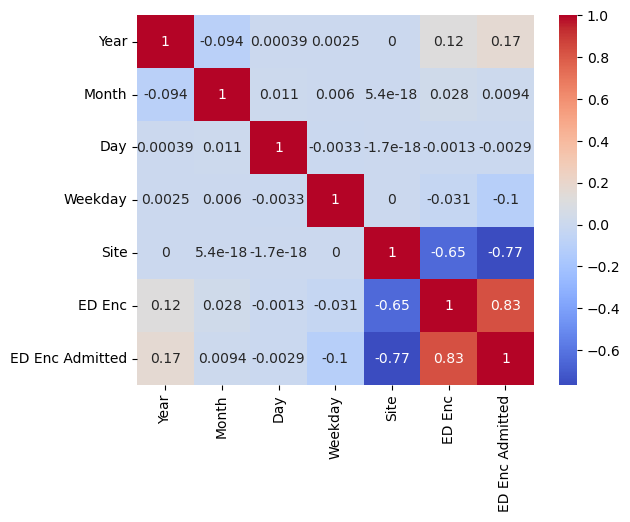

In [57]:
daily_site_data_normal = daily_site_data.filter((pl.col('Year') != 2020) & (pl.col('Year') != 2021))

ax = sns.heatmap(daily_site_data_normal.corr(), annot=True, cmap='coolwarm', xticklabels=daily_site_data_normal.columns, yticklabels=daily_site_data_normal.columns)

# Box plot
Let's compare the the daily ED visits from pre-COVID, during COVID pandemic, and after COVID.  
We can define these periods:
- pre-COVID will be Jan. 1, 2018 up to March 13, 2020 (this was when state of emergency was declared in South Dakota, according to [Wikipedia](https://en.wikipedia.org/wiki/U.S._state_and_local_government_responses_to_the_COVID-19_pandemic))
- during COVID is March 13, 2020 to January 1st, 2020 (cases began to decline following the winter 2020 surge, according to [Keloland](https://www.keloland.com/keloland-com-original/looking-back-2-years-of-covid-19-in-south-dakota/))
- There was also an [Omicron surge](https://doh.sd.gov/press-releases/first-covid-19-omicron-variant-case-detected-in-south-dakota/) from December 22, 2021 to February 1st, 2021
- February 1st, 2021 to August 31st, 2025 is the after COVID period.

In [17]:
daily_site_data_date = daily_site_data.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day")
    ).alias("Date"),
    pl.col("Site").replace_strict(reverse_site_dict)
)

In [30]:
daily_site_period = daily_site_data_date.with_columns(
    pl.when(pl.col("Date") < pl.datetime(2020, 3, 13)).then(pl.lit("pre_covid"))
     .when(pl.col("Date") < pl.datetime(2021, 2, 1)).then(pl.lit("during_covid"))
     .otherwise(pl.lit("post_covid")).alias("Period")
).sort("Site")
daily_site_period.head()

Year,Month,Day,Weekday,Site,ED Enc,ED Enc Admitted,Date,Period
i32,i32,i32,i32,str,i64,i64,datetime[μs],str
2024,8,9,5,"""A""",130,40,2024-08-09 00:00:00,"""post_covid"""
2019,6,6,4,"""A""",112,43,2019-06-06 00:00:00,"""pre_covid"""
2024,9,23,1,"""A""",140,43,2024-09-23 00:00:00,"""post_covid"""
2020,5,4,1,"""A""",102,43,2020-05-04 00:00:00,"""during_covid"""
2024,2,16,5,"""A""",124,49,2024-02-16 00:00:00,"""post_covid"""


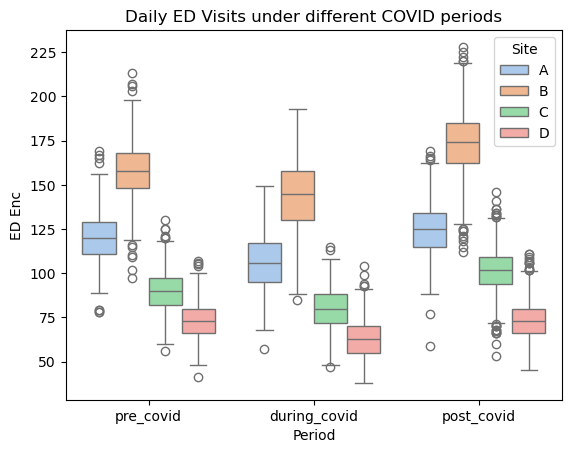

In [35]:
sns.boxplot(data=daily_site_period, x="Period", y="ED Enc", hue="Site", order=["pre_covid", "during_covid", "post_covid"], palette="pastel").set_title("Daily ED Visits under different COVID periods")
plt.show()

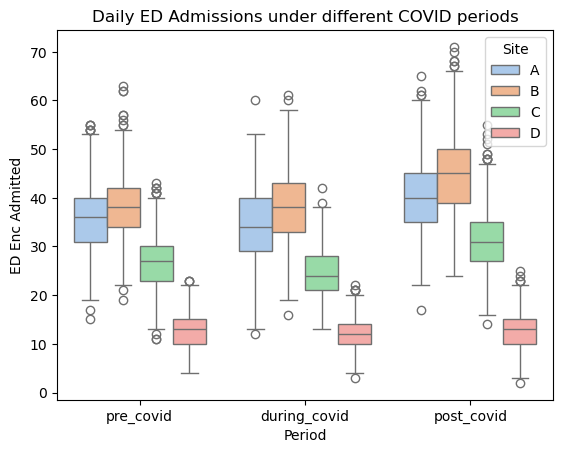

In [37]:
sns.boxplot(data=daily_site_period, x="Period", y="ED Enc Admitted", hue="Site", order=["pre_covid", "during_covid", "post_covid"], palette="pastel").set_title("Daily ED Admissions under different COVID periods")
plt.show()